## Hypothesis: The shapes number of vertices influences the de-novo reconstruction runtime
To test this I want to test this by using the same dataset on different shapes with increasing number of vertixes/edges etc.. My Idea is to first use a rectangle, and then generate multiple polygone with increasing about of edges and see how the runtime behaves.

I think this is a general visualization problem so from the visu community there should be workarounds or solutions for this. Although before jumping into those I should first evaluate which shapes work and which not and then further question how necessary shapes like circles etc. really are for this experiment.

In [16]:
import os
import novosparc
import scanpy as sc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [17]:
# dirname = '/mnt/ramdisk'
dirname = '/dev/shm/ramdisk/'
# dirname = '/data/local/rajewsky/home/vschuma/Jackie/data/GarciaAlsono_uterus/'

fname = os.path.join(dirname,'uterus_histo.h5ad')

# read data
adata = sc.read(fname)

### sample preparation

In [19]:
# filtering excluded cells
col_ct = "Cell type"
included = ~(adata.obs[col_ct] == 'Excluded')
adata = adata[included]

# subset cells
num_cells = 10
sc.pp.subsample(adata, n_obs=num_cells)

genenames = list(adata.var.index)
ngenes = len(genenames)
num_cells, num_genes = adata.shape

print('number of cells: %d' % num_cells)
print('Number of genes: %d' % ngenes)

number of cells: 10
Number of genes: 28614


In [20]:
dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(adata)
is_var_gene = adata.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# alternative 1: variable expressed genes representation
dge_rep = adata.to_df()[var_genes]

### shape and image settings

**geometries**

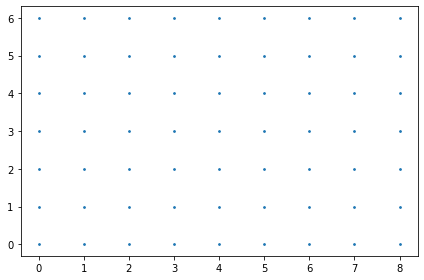

In [21]:
num_locations = 50 # where does this come from?

locations_squared =novosparc.gm.construct_target_grid(num_locations=num_locations)
locations_circle = novosparc.gm.construct_circle(num_locations=num_locations)

tit_size = 15
dpi = 100
fig = plt.scatter(locations_squared[:, 0], locations_squared[:, 1], s=3)
plt.tight_layout()
plt.show()

**random shape images**

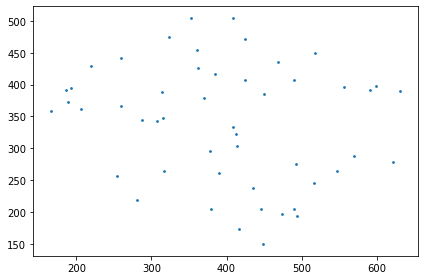

In [23]:
tissue_path = '../novosparc/datasets/tissue_example.png'
locations_from_image = novosparc.gm.create_target_space_from_image(tissue_path)
locations_from_image = locations_from_image[np.random.choice(locations_from_image.shape[0], num_locations), :]
tit_size = 15
dpi = 100
fig = plt.scatter(locations_from_image[:, 0], locations_from_image[:, 1], s=3)
plt.tight_layout()
plt.show()

In [ ]:
# tit_size = 15
# dpi = 100
# fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=dpi)
#
# ax[0].scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)
# ax[1].scatter(locations_from_image[:, 0], locations_from_image[:, 1], s=3)
# ax[2].scatter(locations_circle[:, 0], locations_circle[:, 1], s=3)
#
# ax[0].set_title('Target space available apriori', size=tit_size)
# ax[1].set_title('Prior shape without exact locations', size=tit_size)
# ax[2].set_title('No prior knowledge of target space', size=tit_size)
#
# ax[0].axis('off')
# ax[1].axis('off')
# ax[2].axis('off')
#
# plt.tight_layout()
# plt.show()

### Generate Tissue object

**Square**

In [24]:
%%time
tissue = novosparc.cm.Tissue(dataset=adata, locations=locations_squared)
num_neighbors_s = num_neighbors_t = 5

# since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 0.01 seconds )
CPU times: user 21.7 ms, sys: 138 µs, total: 21.9 ms
Wall time: 20.4 ms


In [25]:
%%time
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 10 cells and 63 locations ... 
Trying with epsilon: 5.00e-03
CPU times: user 909 ms, sys: 5.91 ms, total: 915 ms
Wall time: 884 ms


**Circle**

In [30]:
%%time
tissue = novosparc.cm.Tissue(dataset=adata, locations=locations_circle)
num_neighbors_s = num_neighbors_t = 5

# since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 0.01 seconds )
CPU times: user 20.1 ms, sys: 0 ns, total: 20.1 ms
Wall time: 18.6 ms


In [31]:
%%time
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 10 cells and 50 locations ... 
Trying with epsilon: 5.00e-03
CPU times: user 8.06 s, sys: 0 ns, total: 8.06 s
Wall time: 8.02 s


**Tissue**

In [32]:
%%time
tissue = novosparc.cm.Tissue(dataset=adata, locations=locations_from_image)
num_neighbors_s = num_neighbors_t = 5

# since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 0.02 seconds )
CPU times: user 177 ms, sys: 210 ms, total: 387 ms
Wall time: 37.2 ms


In [33]:
%%time
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 10 cells and 50 locations ... 
Trying with epsilon: 5.00e-03
CPU times: user 2.11 s, sys: 133 ms, total: 2.24 s
Wall time: 2.01 s


## Random thoughts and sources so far

* the first test with just using square, circle, tissue seems like to support the hypothesis. (square: 909ms, tissue: 2.01s, circle: 8.02s)
* next steps here:
    - generate polygones with increasing amount of edges and benchmark runtime (e.g using [OpenCV polylines()](https://www.geeksforgeeks.org/python-opencv-cv2-polylines-method/)
    - also check runtime differences with increasing amount of vertices (num_locations) on 1 or 2 different geometries and shapes


Furthermore my theory on that there should be some optimization material from the visu/comp graphics community looks like the right direction. Here some sources that I found from a fast initial skimm:
* https://docs.unity3d.com/550/Documentation/Manual/OptimizingGraphicsPerformance.html
* also maybe: https://developer.arm.com/documentation/102448/0100/Triangle-and-polygon-usage

I guess one task here now would be to figure out how the mapping process works and how to figure out which geometries etc are used, how to get the infos about it and how to tweak it.

But again - maybe this is not even necessary because of relevance. However, it might be a good thing to include in the documentation/issues of novosparc so ppl are better informed about it.

Also maybe do the test wiht the drosophila data - since there is already more experience and known stuff on it. Although it also could be interesting to test the runtime stuff with different number of genes.